<a href="https://colab.research.google.com/github/felipehigon/Batman/blob/main/Glass_Class_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Libraries
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate
from sklearn.tree import DecisionTreeClassifier, plot_tree
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
from scipy import stats
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
import plotly.express as px
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, classification_report, make_scorer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifier, SGDClassifier
from sklearn import preprocessing, svm
from joblib import dump, load
from sklearn.pipeline import Pipeline, FeatureUnion

#Seed
np.random.seed(123)

# LOAD DATAFRAME AND PRE-PROCCESING

In [ ]:
#dataframe = pd.read_csv('glass.csv', header=0)
dataframe = pd.read_csv('/content/sample_data/glass.csv', header=0)
dataframe.columns = ["refractive_index", "sodium", "magnesium", "aluminum", "silicon", "potassium", "calcium", "barium", "iron", "type_of_glass"]

#dataframe.drop(['iron'],axis=1,inplace=True)
# Remove Outliers
#z = abs(stats.zscore(dataframe))
#dataframe = dataframe[(z < 3).all(axis=1)]


dataframe.shape

(214, 10)

# TRAIN TEST AND VALIDATION DATA

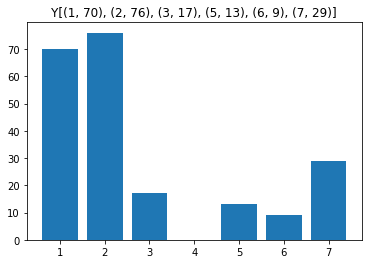

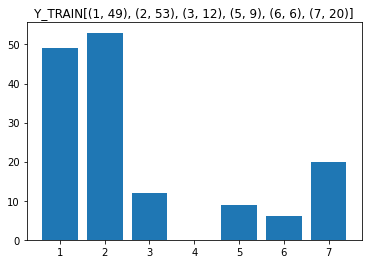

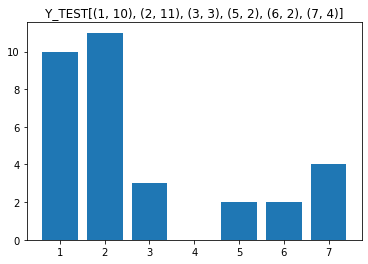

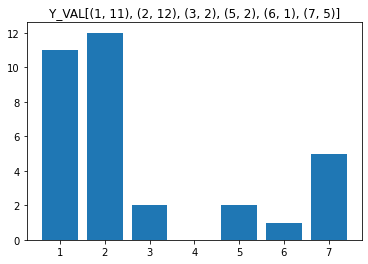

In [ ]:
def plot_classes(Y, title):
  # function to show values on bars
  Y_counts = dict(Y['type_of_glass'].value_counts())
  plt.bar(list(Y_counts.keys()), Y_counts.values())
  #plt.title((Y_counts.items()))
  title += str(sorted(Y_counts.items()))
  plt.title(title)
  plt.show()

def train_test_Val(dataframe,Y_col,Test_size=0.30, Val_size=0.50, Normalize=True):

  X = dataframe.drop([Y_col], axis=1)
  Y = dataframe.loc[:,[Y_col]]

  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = Test_size, stratify=Y)
  
  if Val_size > 0:
    X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size = Val_size, stratify= Y_test)

  # Normalize with X_train for all datas
  if Normalize:
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_test = scaler.transform(X_test)
    X_val = scaler.transform(X_val)
    if Val_size > 0:
      X_train = scaler.transform(X_train)

  plot_classes(Y, "Y")
  plot_classes(Y_train, "Y_TRAIN")
  plot_classes(Y_test, "Y_TEST")
  if Val_size > 0:
    plot_classes(Y_val, "Y_VAL")
    return X, Y, X_train, X_test, Y_train, Y_test, X_val, Y_val
  else:
    return X, Y, X_train, X_test, Y_train, Y_test


X, Y, X_train, X_test, Y_train, Y_test, X_val, Y_val = train_test_Val(dataframe,'type_of_glass')

# Feature Analysis

In [ ]:
dataframe.describe()

,refractive_index,sodium,magnesium,aluminum,silicon,potassium,calcium,barium,iron,type_of_glass
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.



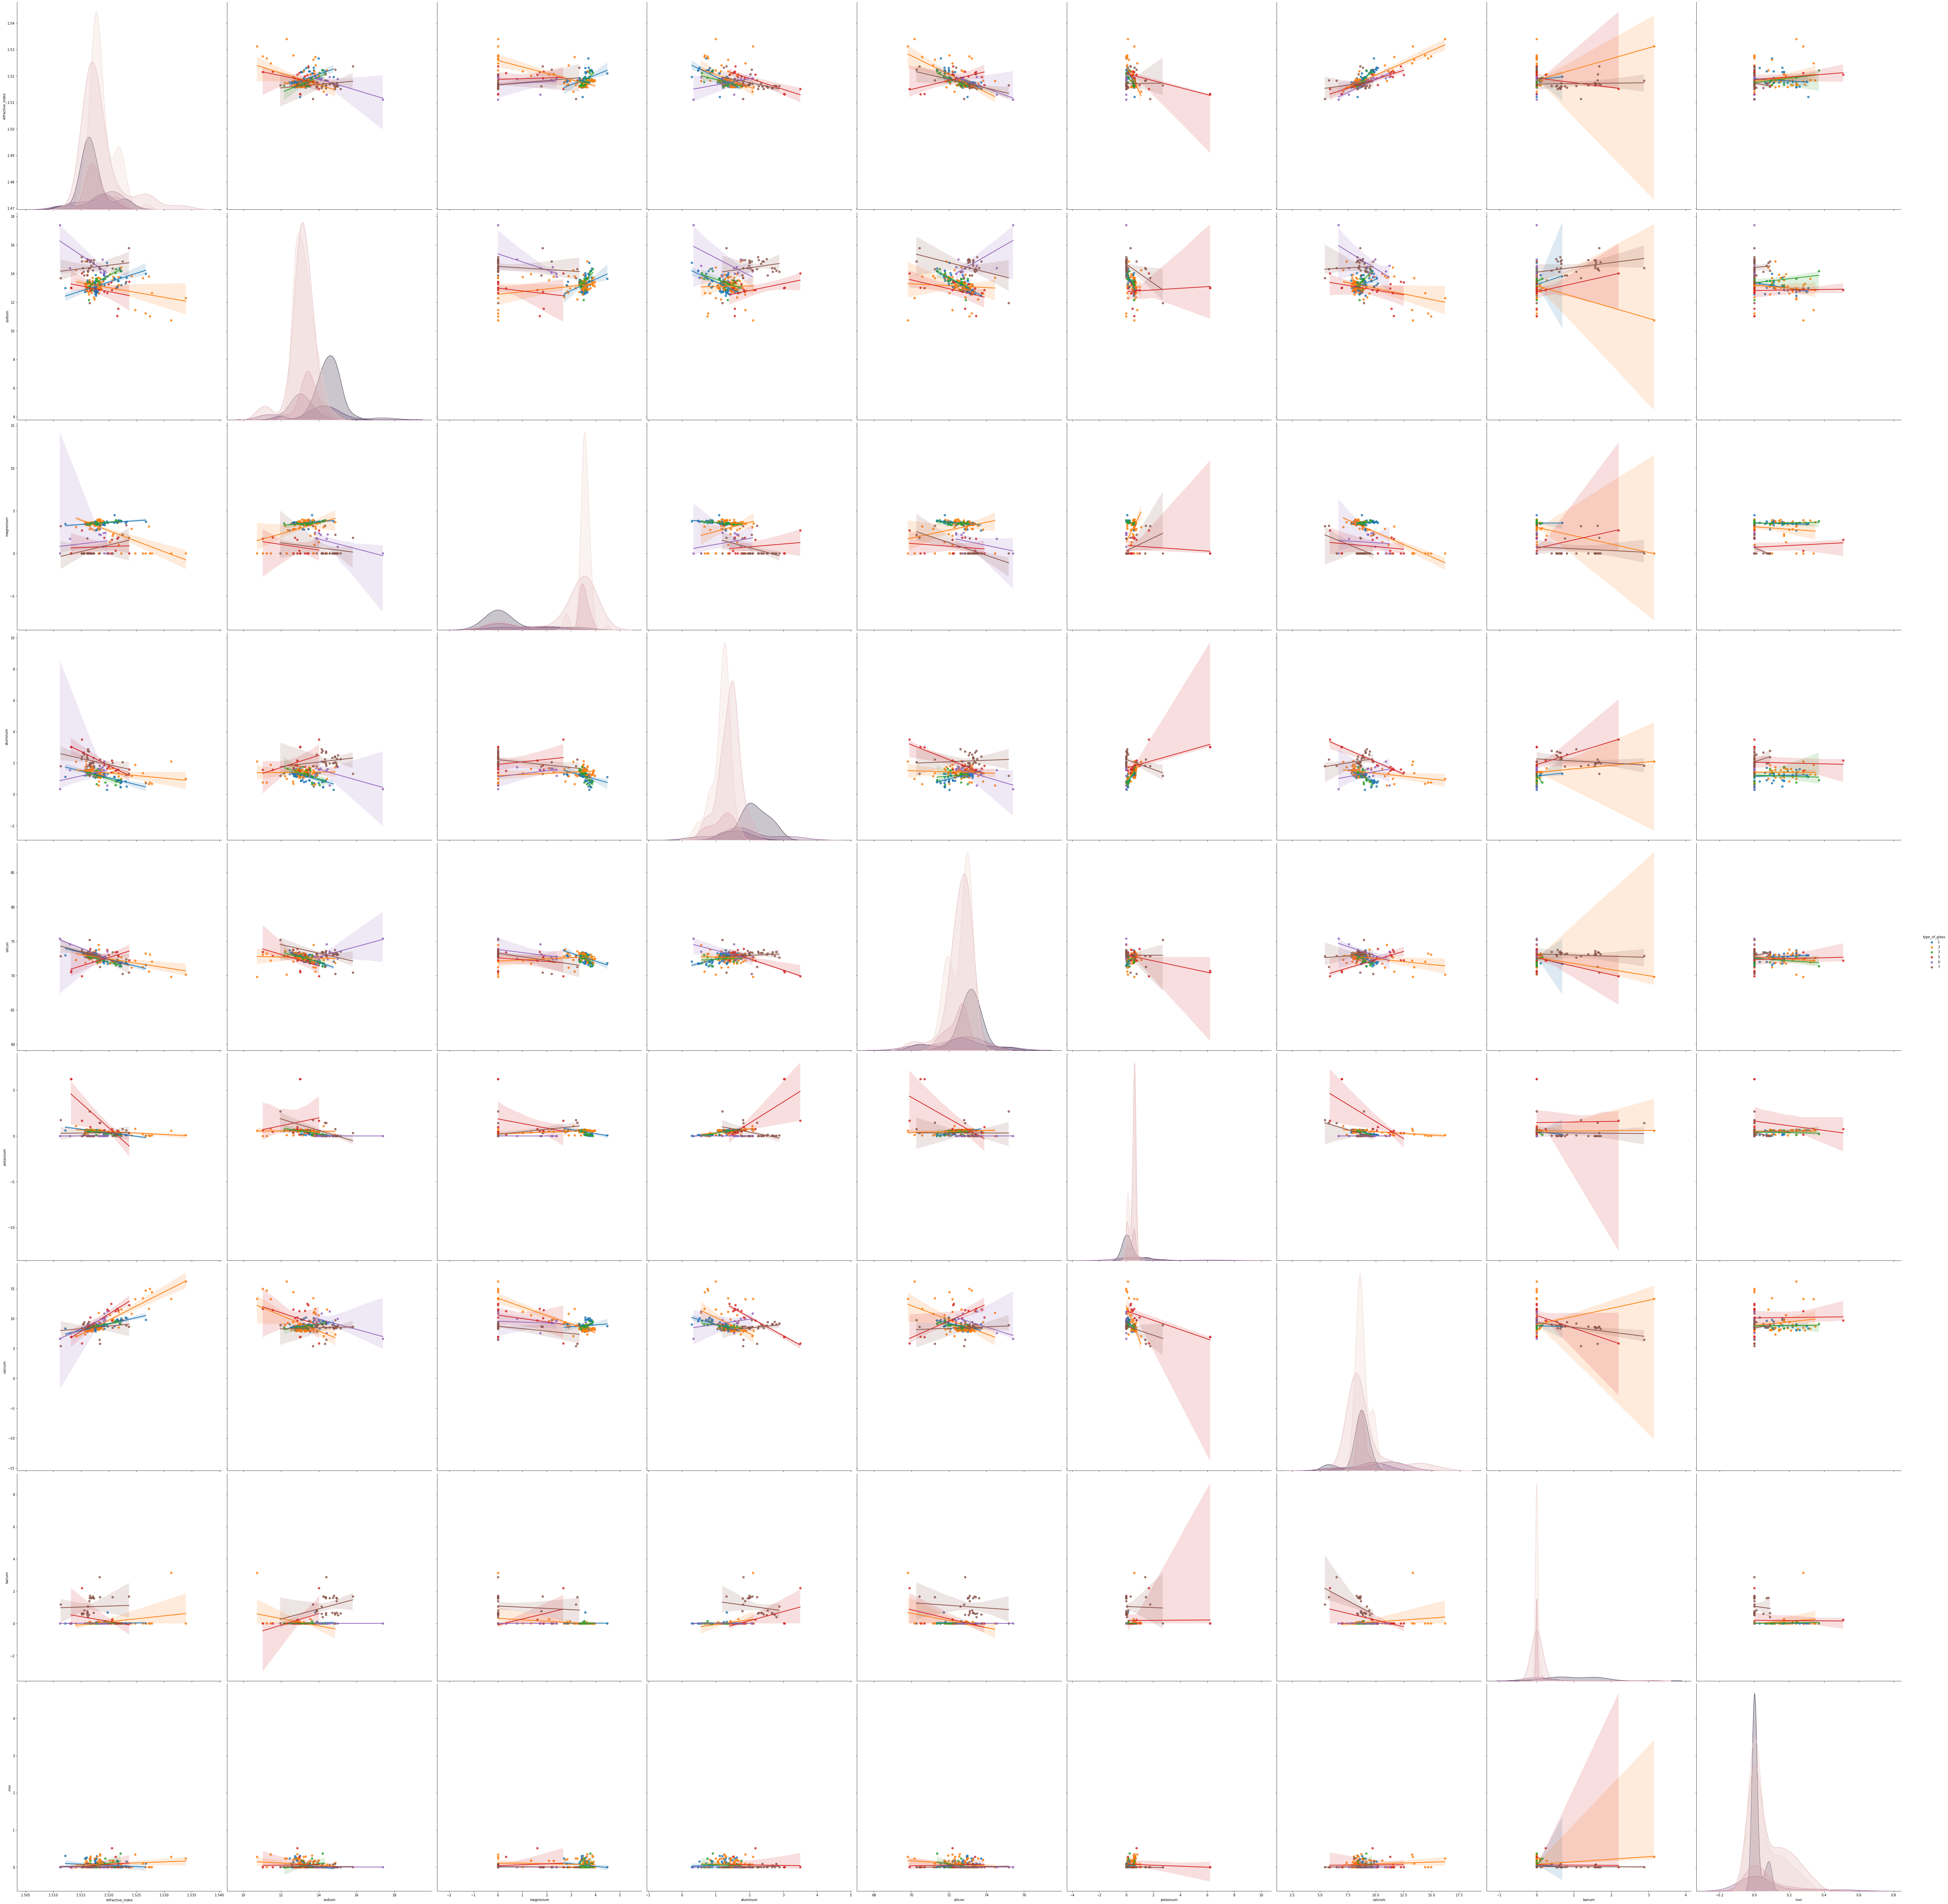

In [ ]:
sns.pairplot(dataframe.dropna(), hue='type_of_glass',height=9,vars=["refractive_index", "sodium", "magnesium", "aluminum", "silicon", "potassium", "calcium", "barium", "iron"],kind='reg')

# Creating models (Pipeline)

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])
    
class StringIndexer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.apply(lambda s: s.cat.codes.replace(
            {-1: len(s.cat.categories)}
        ))

transformer = Pipeline([
    ('features', FeatureUnion(n_jobs=1, transformer_list=[
        # Part 1
        ('boolean', Pipeline([
            ('selector', TypeSelector('bool')),
        ])),  # booleans close
        
        ('numericals', Pipeline([
            ('selector', TypeSelector(np.number)),
            ('imputer',SimpleImputer()),
            ('scaler', StandardScaler()),
            
        ])),  # numericals close
        
        # Part 2
        ('categoricals', Pipeline([
            ('selector', TypeSelector('category')),
            ('labeler', StringIndexer()),
            ('encoder', OneHotEncoder()),
        ]))  # categoricals close
    ])),  # features close
])  # pipeline close

In [ ]:
estimators=[
    ('logistic',LogisticRegression(solver='liblinear',penalty='l2')),
    ('lasso',LogisticRegression(solver='liblinear',penalty='l1')),
    #('ridge',RidgeClassifier()),
    ('elasticnet',SGDClassifier(loss='log', penalty='elasticnet')),
    ('decision_tree',DecisionTreeClassifier()),
    ('random_forest',RandomForestClassifier()),
    ('xgb',XGBClassifier(ojective='reg:logistic')),
    #('svc',LinearSVC()),
    ('deep_nn',MLPClassifier()),
    ('knn',KNeighborsClassifier(n_neighbors=5,weights='distance',algorithm='auto'))
]

pipes={}
for model in estimators:
    pipe=Pipeline(steps=[('data_prep',transformer),model])
    pipe.fit(X_train,np.ravel(Y_train))
    pipes[pipe.steps[1][0]]=pipe

AssertionError: ignored

In [ ]:
# Two metrics roc_auc_ovo (insenitive to class imbalance when average=macro(default))
_metrics={'auc_ovo':'roc_auc_ovo','auc_ovr':'roc_auc_ovr','accuracy':'accuracy'}

estimator_names=[model[0] for model in estimators]

In [ ]:
metrics={'auc_ovo':'roc_auc_ovo','auc_ovr':'roc_auc_ovr','accuracy':'accuracy'}

def plot_estimators(estimators=estimator_names,n_splits=2,metrics=['auc_ovo','auc_ovr','accuracy']):
    metrics={key : _metrics[key] for key in metrics}
    scorers=[]
    labels=[]
    for pipe_name in pipes.keys():
        if pipe_name in estimators:
            pipe=pipes[pipe_name]
            labels.append(pipe_name)
            kf=KFold(n_splits)
            model_score=cross_validate(pipe,X_train,np.ravel(Y_train),scoring=metrics, cv=kf)
            scorers.append(model_score)
    
    score_lists={}
    for metric in metrics:
        score_lists[metric]=[score['test_'+metric] for score in scorers]
    
    for  i,(title, _list) in enumerate(score_lists.items()):
        plt.figure(i)
        plot=sns.boxplot(data=_list).set_xticklabels(labels, rotation=45)
        plt.title(title)

In [ ]:
plot_estimators()

#Hyper Parameter Tuning

In [ ]:
def tune_param(model,param_grid,refit='score',chart=None,data=X_train,target=np.ravel(Y_train),cv=5):
    
    param_grid={model+'__'+key : param_grid[key] for key in param_grid.keys()}

    xgbcv=GridSearchCV(pipes[model],param_grid,refit=refit,cv=cv)
    xgbcv.fit(data,target)

    print('best score: '+str(xgbcv.best_score_))
    print('best params: '+str(xgbcv.best_params_))
    results=pd.DataFrame(xgbcv.cv_results_)
    #print(results.columns)
    if 'line' in chart:
        for i,param in enumerate(param_grid.keys()):
            graph_data=results[['param_'+param,'mean_test_'+refit]]
            graph_data=graph_data.rename(columns={'mean_test_'+refit:'test'})
            graph_data=graph_data.melt('param_'+param, var_name='type',value_name=refit)
            plt.figure(i)
            plot=sns.lineplot(x='param_'+param,y=refit,hue='type',data=graph_data)
            
    if 'heatmap' in chart:
        assert len(param_grid) == 2,  'heatmap only works with 2 params, {} passed'.format(str(len(param_grid)))
        
        param1=list(param_grid.keys())[0]
        param2=list(param_grid.keys())[1]

        graph_data=results[['param_'+param1,'param_'+param2,'mean_test_'+refit]]
        graph_data=graph_data.pivot(index='param_'+param1,columns='param_'+param2,values='mean_test_'+refit)
        sns.heatmap(graph_data,annot=True,xticklabels=True,yticklabels=True).set(xlabel=param2,ylabel=param1)

In [ ]:
pipes['random_forest'].named_steps['random_forest'].get_params()

KeyError: ignored

In [ ]:
pipes['random_forest'].set_params(**{'random_forest__n_estimators': 31})
param_grid={'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}
tune_param('random_forest',param_grid,chart='line')

In [ ]:
metrics.dtypes

In [ ]:
dataframe.dtypes

# Train and Evaluate Functions

In [ ]:
def Matrix(Y_true,Y_pred):
  confm=pd.crosstab(Y_true, Y_pred)
  d_cm=pd.DataFrame(confm, index=None)
  grafica=sns.heatmap(d_cm,cmap='Pastel1', annot=True)
  plt.ylabel('Valores verdaderos')
  plt.xlabel('Predicciones')
  grafica.set(xlabel='Verdaderos', ylabel='Predicciones')
  plt.show()


In [ ]:
def get_class_AUC_ROC_predict_proba(model, x_train, y_train, x_test, y_test):
  import matplotlib.pyplot as plt
  from sklearn.metrics import roc_curve, auc
  from sklearn.multiclass import OneVsRestClassifier
  from sklearn.preprocessing import label_binarize
  
  # Learn to predict each class against the other
  classifier = OneVsRestClassifier(model)
  y_score = classifier.fit(x_train, y_train).predict_proba(x_test)

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()

  for i in range(len(classifier.classes_)):
    fpr[i], tpr[i], _ = roc_curve(label_binarize(y_test, classes=classifier.classes_)[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(label_binarize(y_test, classes=classifier.classes_).ravel(), y_score.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
  
  #Compute macro-average ROC curve and ROC area
  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classifier.classes_))]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(len(classifier.classes_)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= len(classifier.classes_)

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
  # Plot all ROC curves
  # Micro
  plt.figure()
  plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)
  # Macro
  plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

  colors = ['black', 'darkorange', 'blue', 'red', 'green', 'yellow']
  for i, label, color in zip(range(len(classifier.classes_)), classifier.classes_, colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(label, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlim([-0.05, 1.05])
  plt.ylim([-0.05, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Multi-class ROC (Hunger_games)')
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
  
  return plt.show()

In [ ]:
#Transform into 0-1 class probabilities
def new_probs_class(y_test ,pos_class):
    new_probs = []
    
    for value in y_test['type_of_glass']:
        if value == pos_class:
            new_probs.append(1.0)
        else:
            new_probs.append(0.0)
    return new_probs

#Print AUC score and plot ROC curve for each class
def get_class_AUC_ROC(model, x_test, y_test, plot_curve=True):
    #from sklearn.metrics import roc_curve, roc_auc_score
    #import plotly.express as px
    
    i = 0
    auc=[]
    for label in model.classes_:
        y_test_class = new_probs_class(y_test , label)
        
        #Class exists at y_test
        
        if any(y_test_class):
            # AUC score
            y_test_class_auc = roc_auc_score(y_test_class, model.predict_proba(x_test)[:,i])
            auc.append(y_test_class_auc)
            auc_text = f"Class {label} AUC: {y_test_class_auc}"
            
            if plot_curve == True:
                # ROC curve
                fpr, tpr, thresholds = roc_curve(y_test_class, list(model.predict_proba(x_test)[:,i]), drop_intermediate=False)
                df_roc = pd.DataFrame({'fpr':fpr, 'tpr':tpr, 'threshold':thresholds})
                fig = px.line(df_roc, x='fpr', y='tpr', hover_data=['threshold'], title=auc_text)
                fig.show()
            else:
                #print(auc_text)
                pass
        #Class doesn't exist at y_test
        else:
            if plot_curve == True:
                # AUC score
                print(f"Class {label} AUC: There is not any observation for Class {label} from y_test\n\n")
            else:
                print(f"Class {label} AUC: There is not any observation for Class {label} from y_test")    
                
        i=+1
    return auc

In [ ]:
def GridSearch(model, param_grid, scoring, x_train, y_train):
    cv = GridSearchCV(model, param_grid, scoring, cv=5, verbose=1)
    cv.fit(x_train, np.ravel(y_train))
    cv.cv_results_
    model_best = cv.best_estimator_
    return model_best

def GenerateModel(x_train, y_train,x_test, y_test, param_grid, scoring,  plot_curve=True, Print=True, Grid=False):
    
    param_gridR = param_grid.copy()
    param_grid.pop('n_estimators')
    model = DecisionTreeClassifier()
    #model = DecisionTreeClassifier(min_samples_split=2,max_depth=6,criterion='entropy')
    #model.fit(x_train, y_train)
    #score = model.score(x_test, y_test)

    model_best = GridSearch(model, param_grid, scoring, x_train, y_train)
    y_pred=model_best.predict(x_test)
    y_true=y_test.type_of_glass
    if Print:
      print("GRID SEARCH DECISION TREE CLASSIFIER:\n")
      Matrix(y_true,y_pred)
      print(classification_report(y_true, y_pred))
    
    AUC_best=get_class_AUC_ROC(model_best,x_test,y_test,plot_curve)
  
    modelR =RandomForestClassifier(n_estimators=31, ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=model_best.max_depth, max_features=model_best.max_features, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=model_best.min_samples_split,
                       min_weight_fraction_leaf=0.0 ,
                       random_state=None)
    modelR.fit(x_train, np.ravel(y_train))
    y_predR=modelR.predict(x_test)
    if Print:
      print("RANDOM FOREST:\n")
      Matrix(y_true,y_predR)
      print(classification_report(y_true, y_predR))
    
    AUC_R=get_class_AUC_ROC(modelR,x_test,y_test,plot_curve)

    if Grid:
      modelR_best = GridSearch(modelR, param_gridR, scoring, x_train, y_train)
      y_predR2=model_best.predict(x_test)
      if Print:
        print("GRID SEARCH RANDOM FOREST:\n")
        Matrix(y_true,y_predR2)
        print(classification_report(y_true, y_predR2))
        
      AUC_Rbest=get_class_AUC_ROC(modelR_best,x_test,y_test,plot_curve)
      return model_best, modelR, modelR_best, AUC_best, AUC_R, AUC_Rbest
    else:
      return model_best, modelR, AUC_best, AUC_R


#Evaluate Models

In [ ]:
np.random.seed(123)
param_grid = {'max_depth': [3,4,5,6,7,8,9,10,11], 'min_samples_split': [2,3,4,5,6,7], 
              'max_features': list(range(1,10)), 'n_estimators':[30,31]}
scoring="f1_micro"
modelo_AUC_T, modelo_AUC_R, AUC_best, AUC_R = GenerateModel(X_train,Y_train,X_test,Y_test,param_grid,scoring,plot_curve=False, Print=False)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed:    4.2s finished


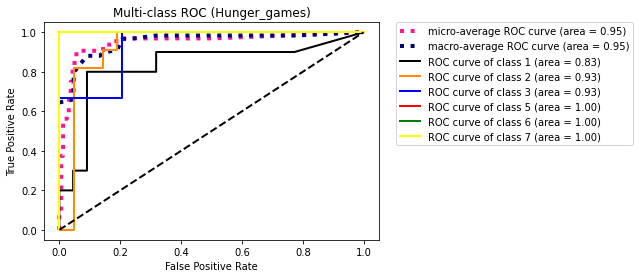

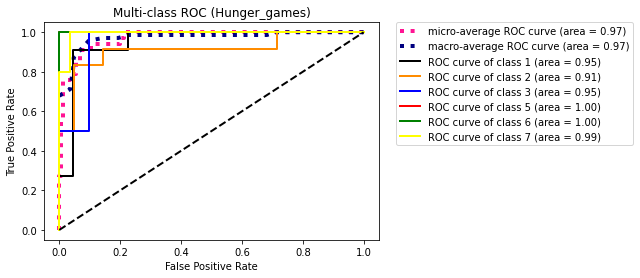

In [ ]:
get_class_AUC_ROC_predict_proba(modelo_AUC_R,X_train,Y_train, X_test, Y_test)
get_class_AUC_ROC_predict_proba(modelo_AUC_R,X_train,Y_train, X_val, Y_val)

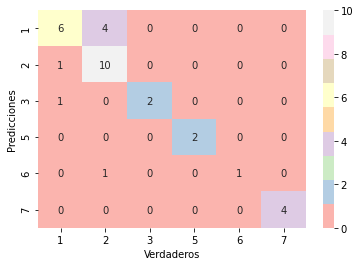

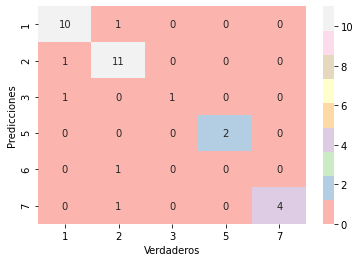

In [ ]:
Matrix(Y_test.type_of_glass,modelo_AUC_R.predict(X_test))
Matrix(Y_val.type_of_glass,modelo_AUC_R.predict(X_val))

In [ ]:
#Search the best models grouping classes 1 2,1 3,1 5.....

a = [1,2,3,5,6,7]
modelos = {}
DecisionTree = []
RandomForest = []
np.random.seed(123)
for x in a:
  for y in a:
    if x!=y:
      print(x,y)
      b= a.copy()
      b.remove(x)
      b.remove(y)
      #print(dict(zip(b,[0,0,0,0])))
      Y_trainXX = Y_train.replace(dict(zip(b,[0,0,0,0])))
      Y_testXX = Y_test.replace(dict(zip(b,[0,0,0,0])))
      param_grid = {'max_depth': [3,4,5,6,7,8,9,10,11], 'min_samples_split': [2,3,4,5,6,7], 
              'max_features': list(range(1,10)), 'n_estimators':[30,31]}
      scoring="f1_micro"
      modelo_T, modelo_R, AUC_best, AUC_R = GenerateModel(X_train,Y_trainXX,X_test,Y_testXX,param_grid,scoring,plot_curve=False, Print=False)
      if sum(AUC_best)>2.5 or sum(AUC_R)>2.5:
        DecisionTree.append(round(sum(AUC_best),2))
        RandomForest.append(round(sum(AUC_R),2))
        lista =[modelo_T, modelo_R, AUC_best, AUC_R]
        clave = (x *10) + y
        modelos[clave] = lista


1 2
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1 3
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1 5
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1 6
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


1 7
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


2 1
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


2 3
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


2 5
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


2 6
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


2 7
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


3 1
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


3 2
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


3 5
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


3 6
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


3 7
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


5 1
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


5 2
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


5 3
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed:    5.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


5 6
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


5 7
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


6 1
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


6 2
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


6 3
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed:    3.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


6 5
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed:    3.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


6 7
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed:    3.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


7 1
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


7 2
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed:    4.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


7 3
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


7 5
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed:    3.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


7 6
Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=1)]: Done 2430 out of 2430 | elapsed:    4.0s finished


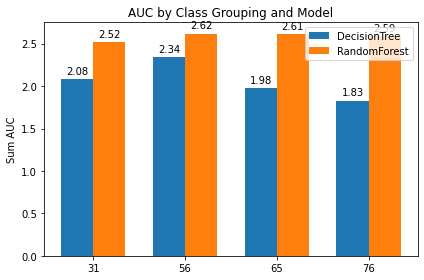

In [ ]:
import matplotlib
import matplotlib.pyplot as plt


labels = modelos.keys()
#DecisionTree = modelos[][4]
#RandomForest = modelos[][5]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, DecisionTree, width, label='DecisionTree')
rects2 = ax.bar(x + width/2, RandomForest, width, label='RandomForest')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Sum AUC')
ax.set_title('AUC by Class Grouping and Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()



def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

# Voting Clasifier with: 31 56 76 AUC_R

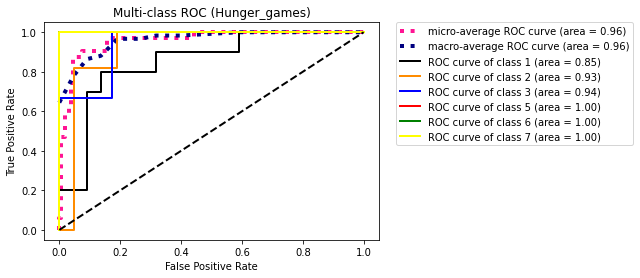

In [ ]:
FinalModel = VotingClassifier(
    estimators=[('C31',modelos[31][1]),('C56',modelos[56][1]),('C76',modelos[76][1]),('AUC',modelo_AUC_R)],
    voting='soft',
)

FinalModel.fit(X_train,np.ravel(Y_train))
Y_predF = FinalModel.predict(X_test)
Y_predFV = FinalModel.predict(X_val)
get_class_AUC_ROC_predict_proba(FinalModel,X_train,Y_train, X_test, Y_test)

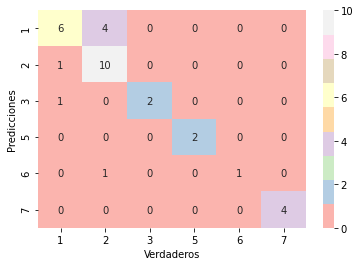

In [ ]:
y_true=Y_test.type_of_glass
Matrix(y_true,Y_predF)

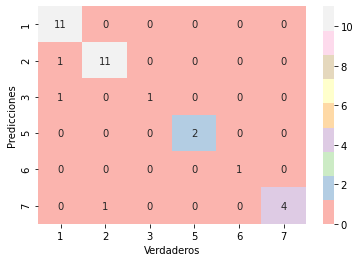

In [ ]:
y_true=Y_val.type_of_glass
Matrix(y_true,Y_predFV)

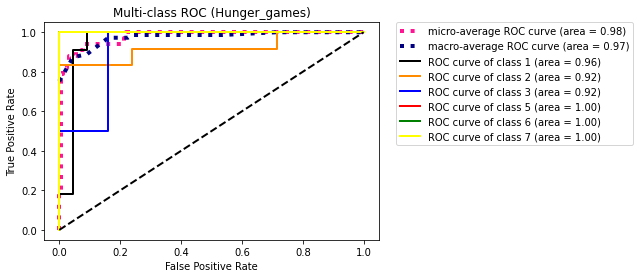

In [ ]:
get_class_AUC_ROC_predict_proba(FinalModel, X_train, Y_train, X_val, Y_val)

# Voting Clasifier with: All. Same Results

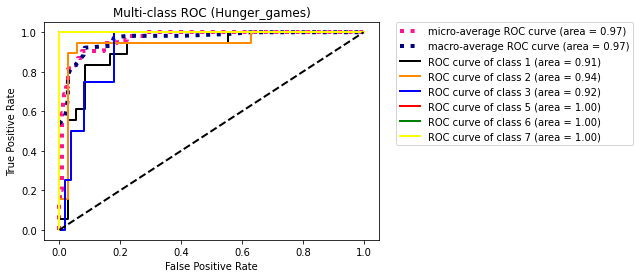

In [ ]:
FinalModel = VotingClassifier(
    estimators=[('C31',modelos[31][1]),('C56',modelos[56][1]),('C75',modelos[75][1]),('67',modelos[67][1]),
                ('C13',modelos[13][1]),('C65',modelos[65][1]),('C57',modelos[57][1]),('AUC',modelo_AUC_R)],voting='soft')


FinalModel.fit(X_train,np.ravel(Y_train))
Y_predF = FinalModel.predict(X_test)
Y_predFV = FinalModel.predict(X_val)
get_class_AUC_ROC_predict_proba(FinalModel,X_train,Y_train, X_test, Y_test)

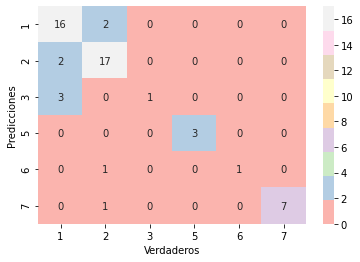

In [ ]:
y_true=Y_test.type_of_glass
Matrix(y_true,Y_predF)

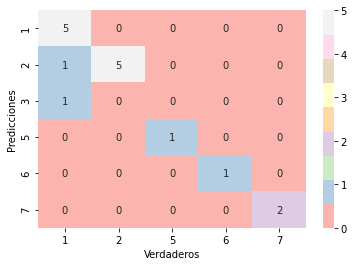

In [ ]:
y_true=Y_val.type_of_glass
Matrix(y_true,Y_predFV)

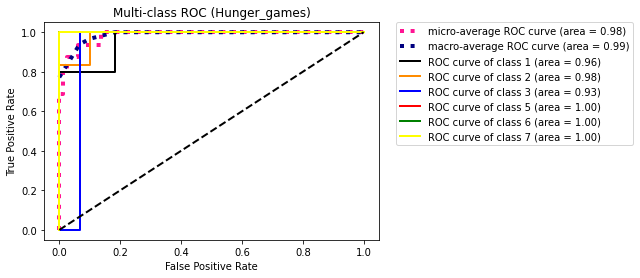

In [ ]:
get_class_AUC_ROC_predict_proba(FinalModel, X_train, Y_train, X_val, Y_val)